In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
import plotly.graph_objects as go
from tabulate import tabulate
from matplotlib import pyplot as plt 
import scipy.integrate as integrate

In [2]:
mp_key = "u9ZAHMoFazUCz7neZTBfXBwCZ5RESH4Z"
mp_id = "mp-567636"

In [3]:
structure = MPRester(mp_key).get_structure_by_material_id(mp_id)
ph_dos = MPRester(mp_key).get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Chaleur spécifique  

In [10]:
temperatures = np.arange(0,1000,5) #len = 200
R = 8.314
nat = len(structure)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*nat*R)

# Modèle d'Einstein

In [5]:
# Définition du modèle d'Einstein
def einstein_model(T, theta_E):
    return (theta_E / T)**2 * np.exp(theta_E / T) / ((np.exp(theta_E / T) - 1)**2)

#minimisation de l'erreur (moindre carré)
err_min = 0
Te = 0 #température d'Einstein (minimisée par moindre carré)
for i in range(1,1000):  #range de températures
    err = 0
    for j in range(1,len(temperatures)):
        err += (einstein_model(temperatures[j], i) - ph_cv[j])**2
    if i == 1:
        err_min = err
    if err < err_min:
        err_min = err
        Te = i
print("Température d'Einstein :", Te,"K")

# cv modèle d'Einstein avec la température d'Einstein Te
cv_einstein = [0] #sinon division par zero avec la 1ere valeure de temperature
for k in range(1,len(temperatures)):
    cv_einstein.append(einstein_model(temperatures[k], Te))

Température d'Einstein : 307 K


# Modèle de Debye

In [6]:
def debye_model(T, theta_D):
    return (3 * (T / theta_D)**3) * integrate.quad(lambda x: (x**4 * np.exp(x)) / (np.exp(x) - 1)**2, 0, theta_D / T)[0]

#minimisation de l'erreur (moindre carré)
err_min = 0
Td = 0 #température d'Einstein (minimisée par moindre carré)
for i in range(1,1000):  #range de températures
    err = 0
    for j in range(1,len(temperatures)):
        err += (debye_model(temperatures[j], i) - ph_cv[j])**2
    if i == 1:
        err_min = err
    if err < err_min:
        err_min = err
        Td = i
print("Température de Debye :", Td,"K")

# cv modèle de Debye avec la température de Debye Td

cv_debye = [0]
for k in range(1,len(temperatures)):
    cv_debye.append(debye_model(temperatures[k], Td))

Température de Debye : 416 K


# Courbes des CV

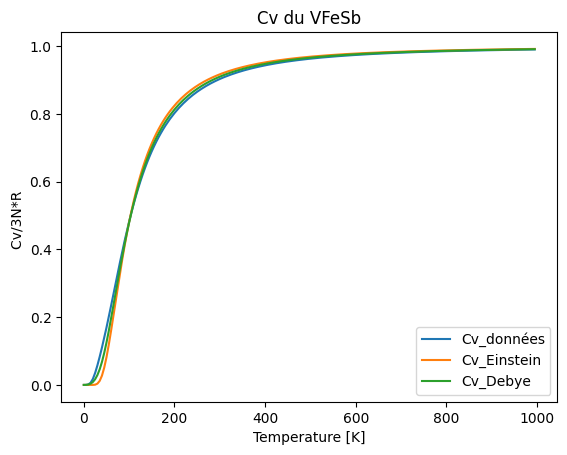

In [7]:
plt.plot(temperatures, ph_cv, label='Cv_données')
plt.plot(temperatures, cv_einstein, label='Cv_Einstein')
plt.plot(temperatures, cv_debye, label='Cv_Debye')
plt.xlabel('Temperature [K]')
plt.ylabel('Cv/3N*R ')
plt.title('Cv du VFeSb')
plt.legend()
plt.show()

# Les 3 densités d'états des phonons correspondantes

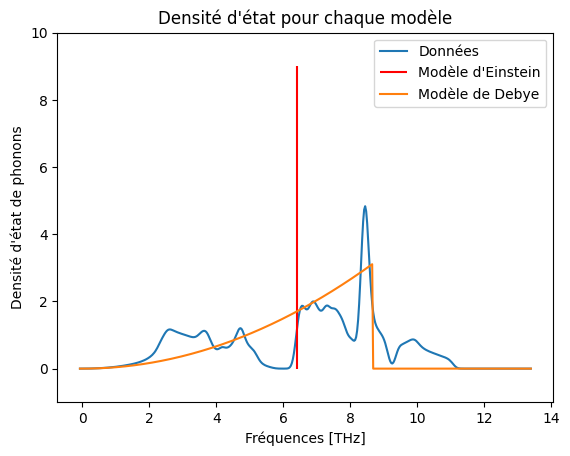

In [9]:
kb = 1.380649e-23 #J/K
thz = 10**12
hbar = 1.055e-34 #J.s

frequences = ph_dos.frequencies 
densites = ph_dos.densities

# Einstein 
omega_e = (Te*kb/hbar)/thz
f_e = omega_e/(2*np.pi) #w = 2 pi f 

#debye
omega_d = (Td*kb/hbar)/thz

densites_d = []
for i in range(len(frequences)):
    omega = 2*np.pi*frequences[i]
    if omega < omega_d:
        densites_d.append((9*nat*omega**2/omega_d**3)*(2*np.pi))
    else:
        densites_d.append(0)
        
   
    
#plot

plt.plot(frequences, densites, label = "Données")
plt.vlines(f_e, 0, 3 * nat, label = "Modèle d'Einstein",color ="r")
plt.plot(frequences, densites_d, label = "Modèle de Debye")
plt.ylim(-1, 10)
plt.xlabel("Fréquences [THz]")
plt.ylabel("Densité d'état de phonons")
plt.title("Densité d'état pour chaque modèle")
plt.legend()
plt.show()